## 1. Data & package loading

In [1]:
%matplotlib inline

import os
from pathlib import Path
import pickle

# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# library for sampling
from imblearn.combine import SMOTEENN

# library for ML
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
SEED = 1111


In [2]:
data_fpath = "/home/tom/PRJ/Riiid/question3/data/data.csv"
# data_dir = Path(os.environ.get("data_dir",'/data'))
model_dir = Path(os.environ.get("model_dir",'/models'))
# data_fpath = data_dir / "data.csv"

df = pd.read_csv(data_fpath)

# column rename
def text_norm(text):
    return text.lower().replace(' ',"_").replace("-","_")
df.columns  = list(map(text_norm,df.columns))

target_column = "adaptivity_level"

df.head()


,gender,age,education_level,institution_type,it_student,location,load_shedding,financial_condition,internet_type,network_type,class_duration,self_lms,device,adaptivity_level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


## 2. Explore Data Analysis

### 2-1. Data type and summary

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               1205 non-null   object
 1   age                  1205 non-null   object
 2   education_level      1205 non-null   object
 3   institution_type     1205 non-null   object
 4   it_student           1205 non-null   object
 5   location             1205 non-null   object
 6   load_shedding        1205 non-null   object
 7   financial_condition  1205 non-null   object
 8   internet_type        1205 non-null   object
 9   network_type         1205 non-null   object
 10  class_duration       1205 non-null   object
 11  self_lms             1205 non-null   object
 12  device               1205 non-null   object
 13  adaptivity_level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [4]:
for column_name in list(df.columns):
    print(f"* {column_name}, {df[column_name].dtype}, {list(df[column_name].unique())}")

* gender, object, ['Boy', 'Girl']
* age, object, ['21-25', '16-20', '11-15', '26-30', '6-10', '1-5']
* education_level, object, ['University', 'College', 'School']
* institution_type, object, ['Non Government', 'Government']
* it_student, object, ['No', 'Yes']
* location, object, ['Yes', 'No']
* load_shedding, object, ['Low', 'High']
* financial_condition, object, ['Mid', 'Poor', 'Rich']
* internet_type, object, ['Wifi', 'Mobile Data']
* network_type, object, ['4G', '3G', '2G']
* class_duration, object, ['3-6', '1-3', '0']
* self_lms, object, ['No', 'Yes']
* device, object, ['Tab', 'Mobile', 'Computer']
* adaptivity_level, object, ['Moderate', 'Low', 'High']


In [5]:
df.nunique().sort_values()

gender                 2
institution_type       2
it_student             2
location               2
load_shedding          2
internet_type          2
self_lms               2
education_level        3
financial_condition    3
network_type           3
class_duration         3
device                 3
adaptivity_level       3
age                    6
dtype: int64

### 2-2. Data visualization

#### Target data

<Axes: xlabel='Adaptivity Level', ylabel='count'>

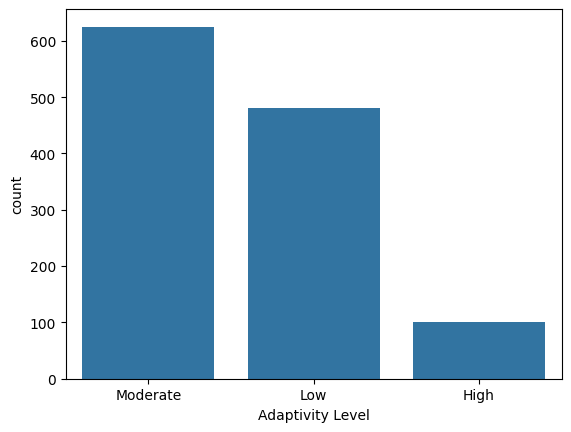

In [7]:
target_column = "Adaptivity Level"

sns.countplot(x=target_column, data = df)

#### categorical column 별 분포 확인

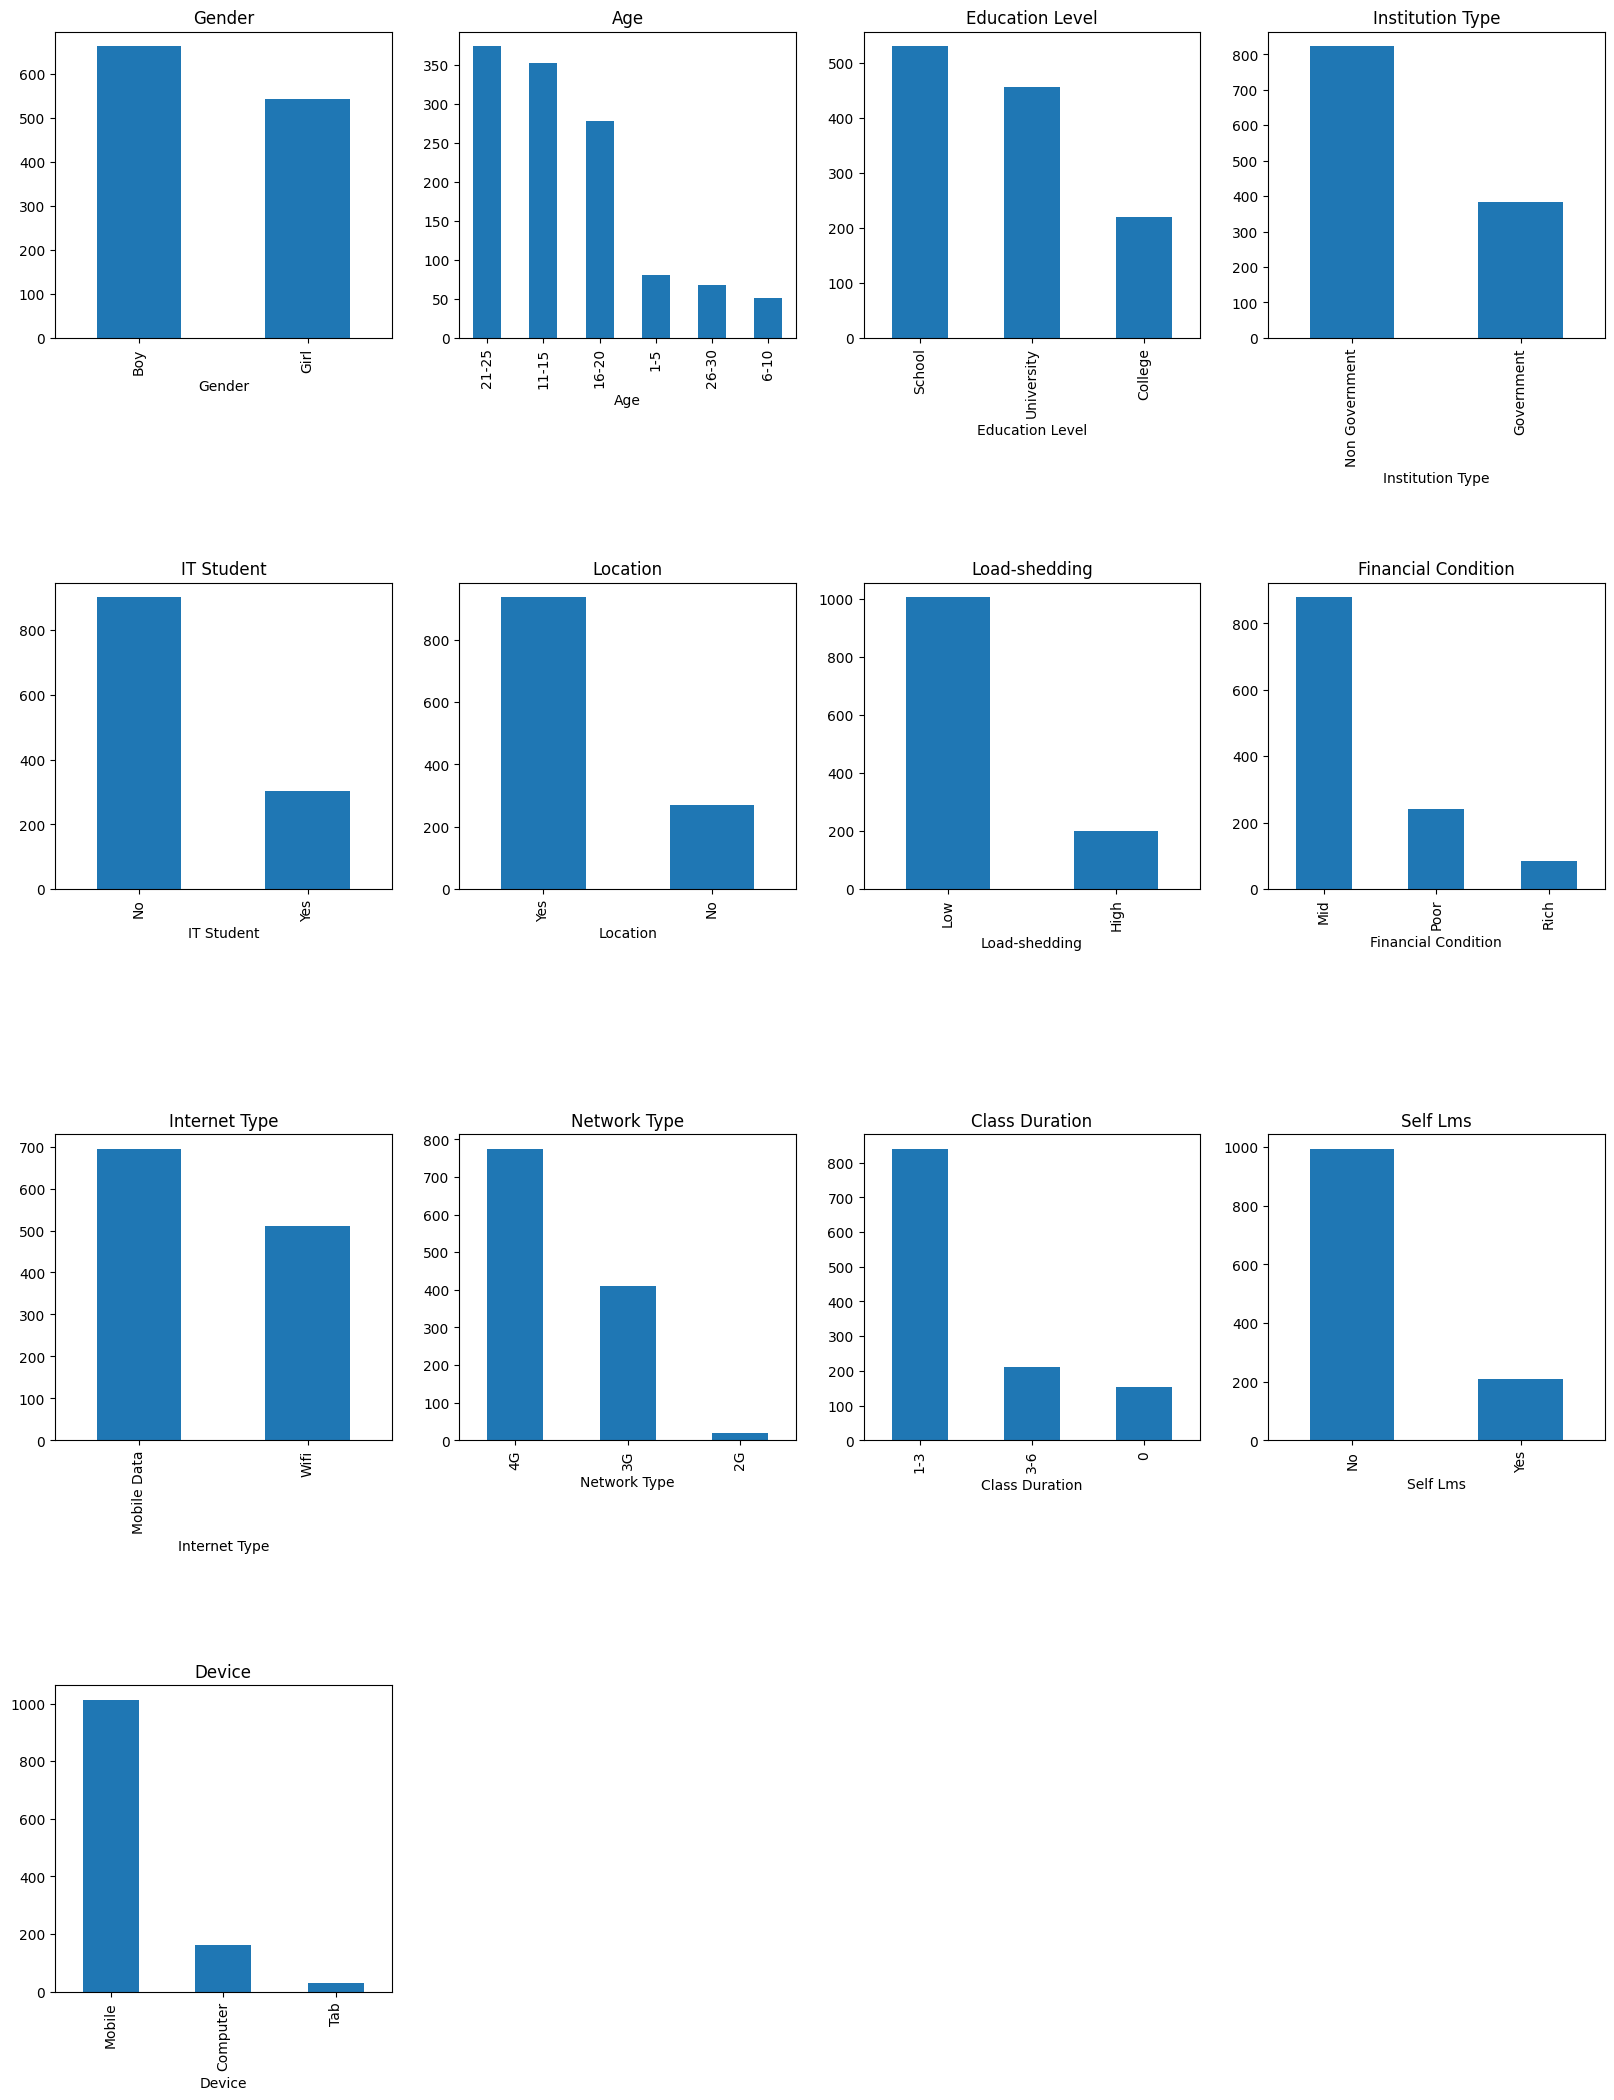

In [8]:

variable_columns = list(df.columns)
variable_columns.remove(target_column)

plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.8, wspace=0.2)

for column_name in variable_columns:
    plt.subplot(4,4,x)
    x +=1 
    df[column_name].value_counts().plot(kind='bar')
    plt.title(column_name)

<Figure size 3000x3000 with 0 Axes>

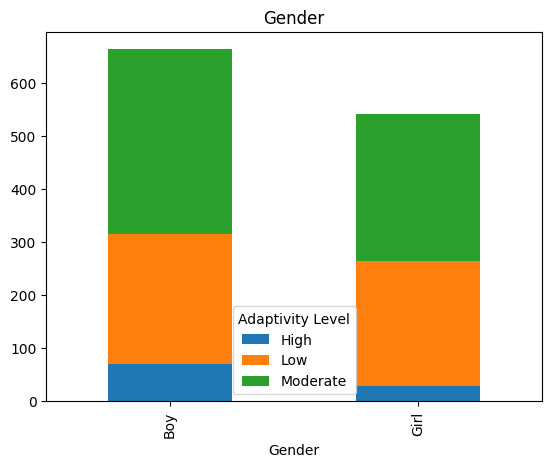

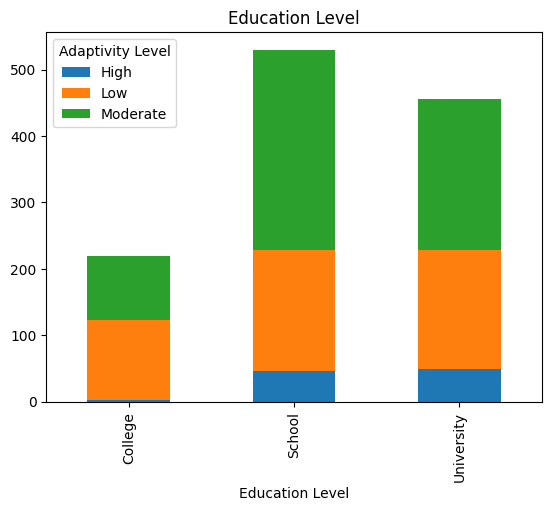

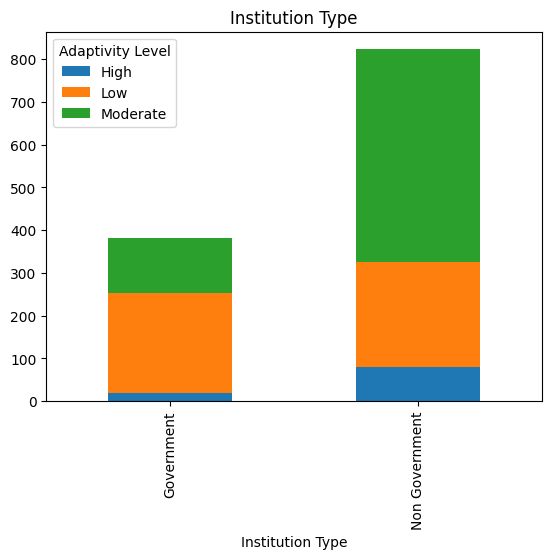

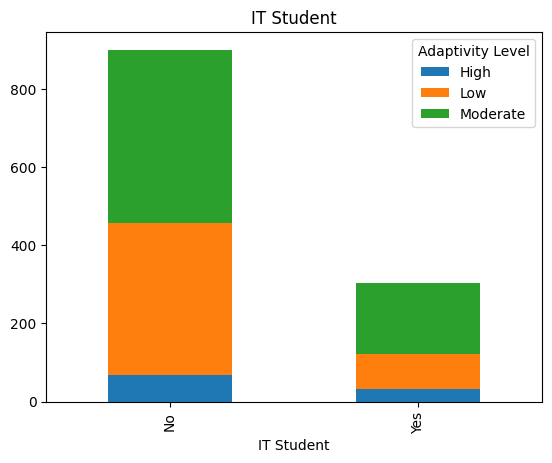

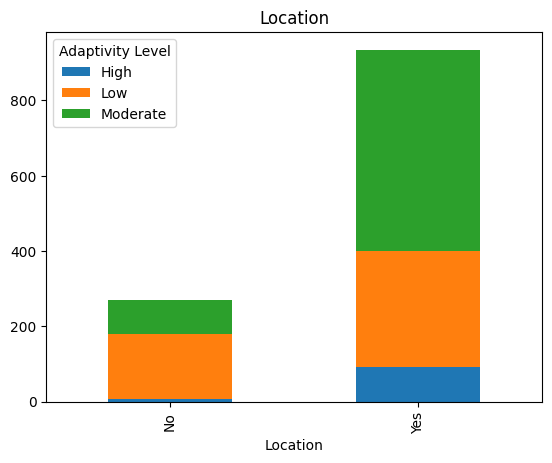

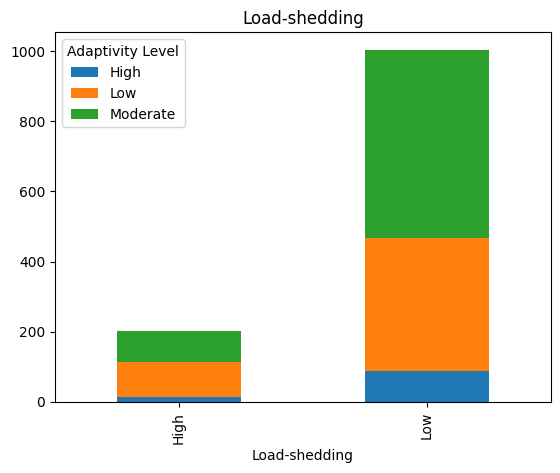

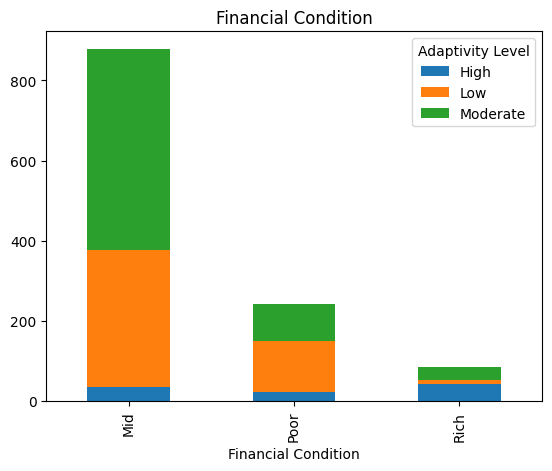

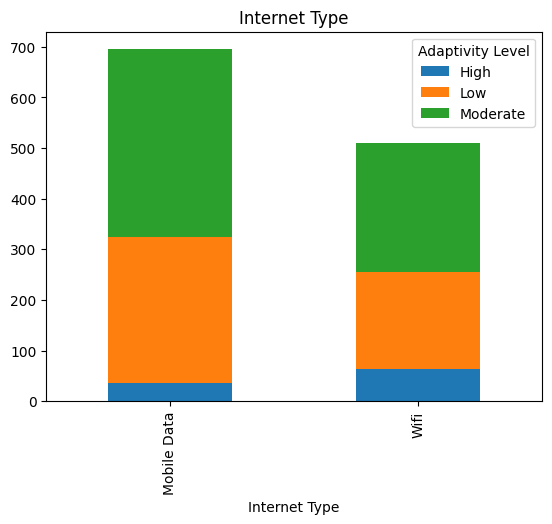

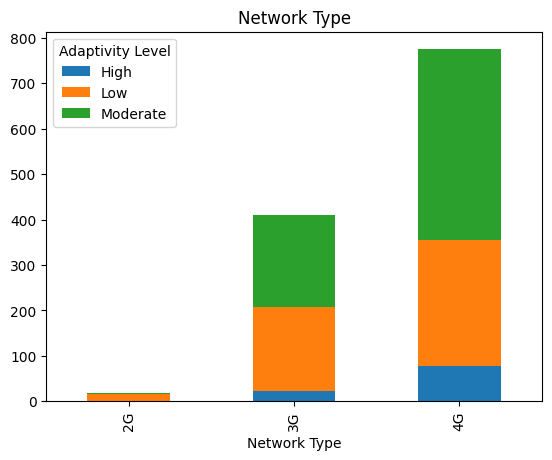

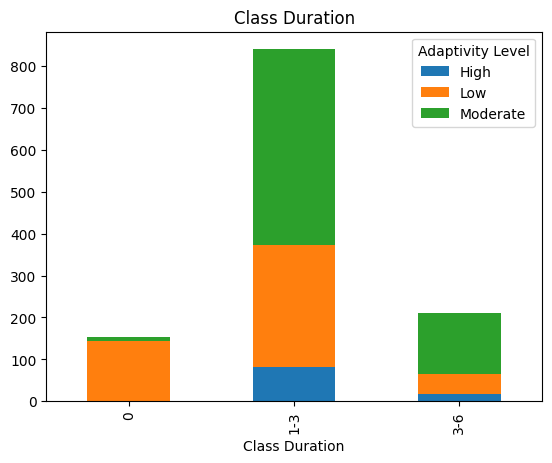

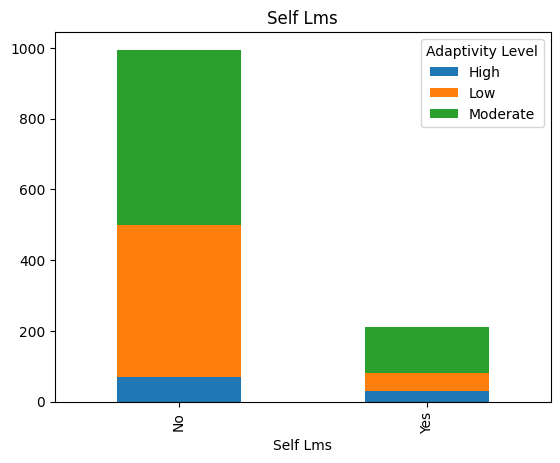

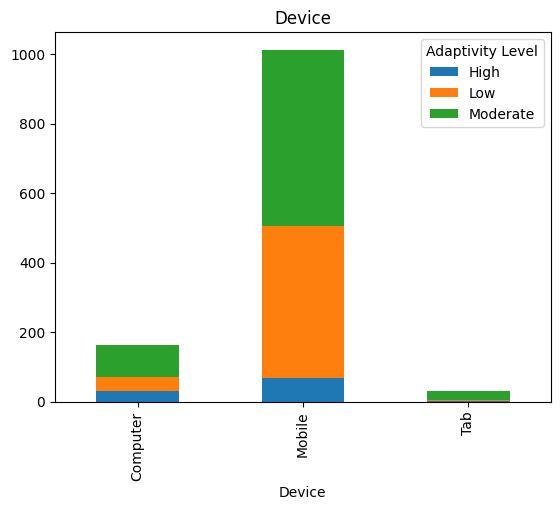

In [9]:
plt.figure(figsize=(30,30))
x = 1
for column_name in variable_columns:
    if column_name == "Age":
        continue
    x += 1
    df.groupby([column_name, target_column]).count()["Age"].unstack().plot(kind="bar",stacked=True)
    plt.title(column_name)
plt.show()

In [10]:
pd.crosstab(df[target_column], df['Location'], normalize="index")

Location,No,Yes
Adaptivity Level,,
High,0.08000,0.92000
Low,0.35625,0.64375
Moderate,0.14560,0.85440


In [11]:
pd.crosstab(df[target_column], df['Location'], normalize="columns")

Location,No,Yes
Adaptivity Level,,
High,0.029630,0.098396
Low,0.633333,0.330481
Moderate,0.337037,0.571123


In [12]:
pd.crosstab(df['Location'],df[target_column], normalize="columns")

Adaptivity Level,High,Low,Moderate
Location,,,
No,0.08,0.35625,0.1456
Yes,0.92,0.64375,0.8544


## 3. Data Processing

#### 3-1. Check missing values

In [6]:
df.isna().sum()

gender                 0
age                    0
education_level        0
institution_type       0
it_student             0
location               0
load_shedding          0
financial_condition    0
internet_type          0
network_type           0
class_duration         0
self_lms               0
device                 0
adaptivity_level       0
dtype: int64

### 3-2. Feature Transformation

In [7]:
Y = df[target_column]
X = df.drop([target_column],axis=1)

#### Label Encoding

In [9]:
label_encoder = LabelEncoder()
Y_enc = label_encoder.fit_transform(Y)
Y_enc

array([2, 2, 2, ..., 2, 1, 2])

#### Feature selection

In [16]:
X

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile
1201,Girl,16-20,College,Non Government,No,No,High,Mid,Wifi,4G,3-6,No,Mobile
1202,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile
1203,Girl,16-20,College,Non Government,No,No,Low,Mid,Wifi,4G,1-3,No,Mobile


#### One-hot encoding

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
 
encoder = OneHotEncoder(sparse=False)
ohe = ColumnTransformer(
    transformers=[("ohe", encoder, X.columns),],
    remainder="passthrough",
)
ohe.set_output(transform="pandas")
ohe.fit(X)
X_enc = ohe.transform(X)
X_enc.head()


/home/tom/ENV/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ohe__gender_Boy,ohe__gender_Girl,ohe__age_1-5,ohe__age_11-15,ohe__age_16-20,ohe__age_21-25,ohe__age_26-30,ohe__age_6-10,ohe__education_level_College,ohe__education_level_School,...,ohe__network_type_3G,ohe__network_type_4G,ohe__class_duration_0,ohe__class_duration_1-3,ohe__class_duration_3-6,ohe__self_lms_No,ohe__self_lms_Yes,ohe__device_Computer,ohe__device_Mobile,ohe__device_Tab
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [17]:
X_enc = pd.get_dummies(X)
X_enc

,Gender_Boy,Gender_Girl,Age_1-5,Age_11-15,Age_16-20,Age_21-25,Age_26-30,Age_6-10,Education Level_College,Education Level_School,...,Network Type_3G,Network Type_4G,Class Duration_0,Class Duration_1-3,Class Duration_3-6,Self Lms_No,Self Lms_Yes,Device_Computer,Device_Mobile,Device_Tab
0,True,False,False,False,False,True,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True
1,False,True,False,False,False,True,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
2,False,True,False,False,True,False,False,False,True,False,...,False,True,False,True,False,True,False,False,True,False
3,False,True,False,True,False,False,False,False,False,True,...,False,True,False,True,False,True,False,False,True,False
4,False,True,False,False,True,False,False,False,False,True,...,True,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,False,True,False,False,True,False,False,False,True,False,...,False,True,False,True,False,True,False,False,True,False
1201,False,True,False,False,True,False,False,False,True,False,...,False,True,False,False,True,True,False,False,True,False
1202,True,False,False,True,False,False,False,False,False,True,...,True,False,False,True,False,True,False,False,True,False
1203,False,True,False,False,True,False,False,False,True,False,...,False,True,False,True,False,True,False,False,True,False


#### Sampling for imbalanced data (combined sampling)
- SMOTEENN: SMOTE + ENN


In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_enc,Y_enc,test_size=0.3, random_state=SEED)

In [16]:
X_train

,ohe__gender_Boy,ohe__gender_Girl,ohe__age_1-5,ohe__age_11-15,ohe__age_16-20,ohe__age_21-25,ohe__age_26-30,ohe__age_6-10,ohe__education_level_College,ohe__education_level_School,...,ohe__network_type_3G,ohe__network_type_4G,ohe__class_duration_0,ohe__class_duration_1-3,ohe__class_duration_3-6,ohe__self_lms_No,ohe__self_lms_Yes,ohe__device_Computer,ohe__device_Mobile,ohe__device_Tab
197,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
514,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
350,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
899,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
674,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
741,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
311,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## 4. Model Training

In [17]:
model = LogisticRegression(C=1, class_weight="balanced", random_state=SEED, multi_class='ovr',n_jobs=2,solver='lbfgs').fit(X_train,Y_train)

print(f"Training Result: {model.score(X_train, Y_train)*100:.2f} %")
print(f"Test Result: {model.score(X_val, Y_val)*100:.2f} %")

Training Result: 70.70 %
Test Result: 65.75 %


In [18]:
X_train_pred = model.predict(X_train)
X_val_pred = model.predict(X_val)
print(f"Metric: Train data\n{classification_report(Y_train,X_train_pred)}")

Metric: Train data
              precision    recall  f1-score   support

           0       0.41      0.81      0.54        67
           1       0.75      0.73      0.74       342
           2       0.77      0.68      0.72       434

    accuracy                           0.71       843
   macro avg       0.64      0.74      0.67       843
weighted avg       0.73      0.71      0.71       843



In [19]:
print(f"Metric: Validation data\n{classification_report(Y_val,X_val_pred)}")

Metric: Validation data
              precision    recall  f1-score   support

           0       0.40      0.67      0.50        33
           1       0.67      0.66      0.66       138
           2       0.73      0.65      0.69       191

    accuracy                           0.66       362
   macro avg       0.60      0.66      0.62       362
weighted avg       0.68      0.66      0.66       362



In [24]:
# model_path = model_dir / "model.pkl"
model_path ="/home/tom/PRJ/Riiid/question3/models/model.pkl"

with open(model_path,'wb') as f:
    pickle.dump(model,f)

In [ ]:
# model_path = model_dir / "model.pkl"
label_encoder_path ="/home/tom/PRJ/Riiid/question3/models/label_encoder.pkl"

with open(label_encoder_path,'wb') as f:
    pickle.dump(label_encoder,f)

### Load the model from disk

In [23]:
with open(model_path,'rb') as f:
    loaded_model = pickle.load(f)

X_pred = loaded_model.predict(X_val)
X_pred

array([2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0,
       1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 0, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 0, 1, 1, 2,
       2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2,
       0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2,
       1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 0, 0, 1, 2, 2, 2,
       0, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0,
       1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 2,